In [1]:
import requests
from bs4 import BeautifulSoup
import sqlite3 as lite
import time
from datetime import datetime
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Create database connection
try:
    conn = lite.connect('Punk.db')
    print('connection was successful')
except Exception as e:
    print('there was an error with connectiong to the DB')

cur = conn.cursor()

connection was successful


In [4]:
#Create table to store user information
cur.execute(
    """CREATE TABLE IF NOT EXISTS Punk_Users(
        user_number INTEGER PRIMARY KEY, 
        punk_id Text UNIQUE NOT NULL)"""
        )
conn.commit()

In [5]:
#Create table to store transaction type
cur.execute(
    """CREATE TABLE IF NOT EXISTS Transaction_Type(
        transaction_id INTEGER, 
        transaction_type Text UNIQUE NOT NULL, 
        PRIMARY KEY(transaction_id))"""
        )
conn.commit()

In [6]:
#Create table to store transaction information
cur.execute(
    """CREATE TABLE IF NOT EXISTS Transactions(
        transaction_number INTEGER, 
        T_date TEXT, 
        transaction_type INTEGER, 
        Punk_Nr INTEGER, 
        T_from INTEGER, 
        T_to INTEGER, 
        amount INTEGER, 
        PRIMARY KEY(transaction_number), 
        FOREIGN KEY(transaction_type) REFERENCES Transaction_Type(transaction_id), 
        FOREIGN KEY(T_from) REFERENCES Punk_Users(user_number), 
        FOREIGN KEY(T_to) REFERENCES Punk_Users(user_number))"""
        )
conn.commit()

In [7]:
#Scrape website and store data in database
#Change inputs into range() to scrape multiple CryptoPunks
for j in range(0, 1):   
    number = 200 + j
    url = 'https://www.larvalabs.com/cryptopunks/details/'
        
    website = requests.get(url + str(number)).text
    soup = BeautifulSoup(website, 'html5lib')
    table = soup.find_all('tr')
    
    for i in table[1:]:
        #Store table data as list
        x = list(i.find_all('td'))
        From = x[1].text
        
        #Insert values into the Punk_Users table
        try:
            cur.execute("INSERT INTO Punk_Users VALUES (NULL, ?)", [x[1].text])
            cur.execute("INSERT INTO Punk_Users VALUES (NULL, ?)", [x[2].text])
            conn.commit()
        except:
            print('Error inserting into Users table')
        
        #Insert data into the Transaction_Type table
        try:
            cur.execute("INSERT INTO Transaction_Type VALUES (NULL, ?)", [x[0].text.strip()])
            conn.commit()
        except:
            print('Error inserting into Transaction_type table')
            
        #Insert into Transaction table
        #Format the date befor entering it into table
        date_object = datetime.strptime(x[4].text, "%b %d, %Y")
        date = date_object.strftime("%Y-%m-%d")
        
        #Get Transaction type id and store that value in table
        trans_id = cur.execute("""SELECT transaction_id FROM Transaction_Type WHERE transaction_type == ?""", [x[0].text.strip()]).fetchall()

        #Get id from Users table
        From_id = cur.execute("""SELECT user_number FROM Punk_Users WHERE punk_id == ?""", [x[1].text]).fetchall()
        To_id = cur.execute("""SELECT user_number FROM Punk_Users WHERE punk_id == ?""", [x[2].text]).fetchall()
        
        #Extract only the dollar value and omit any symbols
        amt = re.search(r'\(\$(.*?)\)', x[3].text)
        if amt == None:
            amount = 0
        else:
            amount = amt.group(1).replace(',', '')
            
        #Store transaction information in table
        try:
            cur.execute("""INSERT INTO Transactions VALUES (NULL, ?, ?, ?, ?, ?, ?)""", (date, trans_id[0][0], number, From_id[0][0], To_id[0][0], amount))
            conn.commit()
        except:
            print('Error inserting into transaction table')
            
        time.sleep(1)

Error inserting into Users table
Error inserting into Transaction_type table
Error inserting into Users table
Error inserting into Transaction_type table


In [8]:
#Q: Report the punk with the highest traded price in the sample.
result_3 = cur.execute(
    """SELECT Punk_Nr, amount 
    FROM Transactions 
    WHERE transaction_type = (SELECT transaction_id FROM Transaction_Type WHERE transaction_type == 'Sold') AND amount > 0 
    ORDER BY amount DESC LIMIT 1;"""
    )
conn.commit()
result_3.fetchall()

[(561, '2.38M')]

In [24]:
#Q: Report which punk was traded the most.
result_4 = cur.execute(
    """SELECT Punk_Nr, COUNT(Punk_Nr) 
    FROM Transactions 
    WHERE transaction_type = (SELECT transaction_id FROM Transaction_Type WHERE transaction_type == 'Sold') AND amount > 0 
    GROUP BY Punk_Nr 
    ORDER BY COUNT(Punk_Nr) DESC LIMIT 1;"""
    )
conn.commit()
result_4.fetchall()

[(486, 13)]

In [10]:
#Q: Plot the average traded price by day in the DB.
query = """
    SELECT T_date, COUNT(Punk_Nr), AVG(amount) 
    FROM Transactions 
    WHERE transaction_type = (SELECT transaction_id FROM Transaction_Type WHERE transaction_type == 'Sold') AND amount > 0 
    GROUP BY T_date
    """

trans_df = pd.read_sql_query(query, conn)
trans_df.sort_values(by='T_date', inplace=True)
trans_df

,T_date,COUNT(Punk_Nr),AVG(amount)
0,2017-06-23,1,3.00
1,2017-06-27,1,157.00
2,2017-07-03,1,304.00
3,2017-07-05,1,399.00
4,2017-07-06,4,187.75
...,...,...,...
330,2024-02-07,1,141209.00
331,2024-02-11,1,150347.00
332,2024-02-18,1,159642.00
333,2024-02-19,1,165514.00


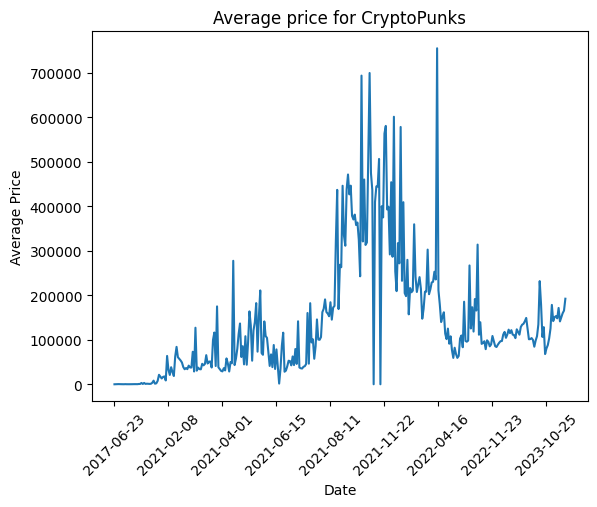

In [11]:
#Plot Average trade price per day
plt.figure()
plt.plot(trans_df['T_date'], trans_df['AVG(amount)'])
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.title('Average price for CryptoPunks')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))
plt.xticks(rotation=45)
plt.show()

In [12]:
#Q: What user has the most valuable portfolio, not necessarily at one time 
query2 = """SELECT 
    PU1.user_number AS FromUserNumber,
    PU1.punk_id AS FromPunkID,
    PU2.user_number AS ToUserNumber,
    PU2.punk_id AS ToPunkID,
    T.transaction_number,
    T.T_date,
    T.transaction_type,
    T.Punk_Nr,
    T.amount
FROM 
    Transactions T
JOIN 
    Punk_Users PU1 ON T.T_from = PU1.user_number
JOIN 
    Punk_Users PU2 ON T.T_to = PU2.user_number
WHERE 
    transaction_type = (SELECT transaction_id FROM Transaction_Type WHERE transaction_type == 'Sold') AND T.amount > 0
ORDER BY
    T.amount;
"""


In [13]:
trans_df_q6 = pd.read_sql_query(query2, conn)
trans_df_q6

,FromUserNumber,FromPunkID,ToUserNumber,ToPunkID,transaction_number,T_date,transaction_type,Punk_Nr,amount
0,6,0xc352b5,537,0x5b098b,5128,2017-06-23,9,544,3
1,6,0xc352b5,10,0x6611fe,7672,2017-09-16,9,688,74
2,6,0xc352b5,10,0x6611fe,1969,2017-07-11,9,346,90
3,6,0xc352b5,869,0x0d8040,4740,2017-07-28,9,516,115
4,6,0xc352b5,26,0x00bd3a,2100,2017-07-24,9,355,135
...,...,...,...,...,...,...,...,...,...
626,564,0x79457a,563,0x2cd808,2727,2021-08-28,9,406,1.02M
627,208,0xf18fce,207,0x86292f,860,2021-10-19,9,273,1.03M
628,991,0xd1e70f,990,0x18ee9c,5439,2021-08-06,9,561,1.04M
629,357,0xddd0e9,461,thecitad…,2145,2021-10-26,9,364,1.52M


In [14]:
#Transform string values into floats in amount column
for i in np.arange(0, len(trans_df_q6['amount'])):
    try:
        if type(trans_df_q6['amount'][i]) == str:
            trans_df_q6['amount'][i] = float(trans_df_q6['amount'][i].replace('M', ''))*1000000
    except:
        continue
    
trans_df_q6[trans_df_q6['amount'] == max(trans_df_q6['amount'])]['ToPunkID']

/var/folders/rm/zw5ycl5x75vd7k4_ycrpc8780000gn/T/ipykernel_73237/2897580559.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trans_df_q6['amount'][i] = float(trans_df_q6['amount'][i].replace('M', ''))*1000000


630    0xdfa6e4
Name: ToPunkID, dtype: object

In [26]:
#Close DB connection
conn.close()